In [1]:
import time

import numpy as np
import pandas as pd

from Utils.discrete_family import discrete_family
from Utils.barrier_affine import solve_barrier_tree, solve_barrier_tree_nonneg, solve_barrier_tree_box_PGD
from CART import RegressionTree
from scipy.interpolate import interp1d
from scipy.stats import multivariate_normal as mvn
from Utils.plotting import  *
from Utils.simulation_helpers import *
from scipy.stats import norm as ndist

# For tree-values
import rpy2.robjects.packages as rpackages
from rpy2.robjects.vectors import StrVector

# Select a CRAN mirror to download from
utils = rpackages.importr('utils')
utils.chooseCRANmirror(ind=1)  # Select the first mirror

# Install 'remotes' if it's not already installed
if not rpackages.isinstalled('remotes'):
    utils.install_packages(StrVector(('remotes',)))

import rpy2.robjects as ro

from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
from rpy2.robjects import numpy2ri
%load_ext rpy2.ipython

# Main ideas
1. Generate data from the tree-values setting:
> We simulate $X \in \mathbb{R}^{n \times p}$ with $n=200, p=10, X_{i j} \stackrel{i . i . d .}{\sim} N(0,1)$, and $y \sim N_n\left(\mu, \sigma^2 I_n\right)$ with $\sigma=5$ and $\mu_i=b \times\left[1_{\left(x_{i, 1} \leq 0\right)} \times\left\{1+a 1_{\left(x_{i, 2}>0\right)}+1_{\left(x_{i, 3} \times x_{i, 2}>0\right)}\right\}\right]$. 
2. Fix a maximum depth $max\_depth$, e.g. $5$.
3. Use naive inference, tree-values, and our proposed method to fit the tree.
4. Coverage rate comparison: compare the average coverage rate over CIs for terminal nodes in each simulation.
5. Average length comparison: compare the average CIs lengths for terminal nodes in each simulation.
6. Selection quality comparison: 
a. generate the same dataset with same $X, \mu$ but new $\epsilon$,
b. generate new $X, \mu$, \epsilon$ using the same parameters,
compare the MSE of fitted trees on this test set.

In [2]:
# Activate automatic conversion between pandas and R data frames
pandas2ri.activate()

# Import R libraries
treevalues = importr('treevalues')
rpart = importr('rpart')

def tree_values_inference(X, y, mu, sd_y, max_depth=5, level=0.1,
                          X_test=None):
    # Convert the NumPy matrix to an R matrix
    X_r = numpy2ri.py2rpy(X)
    y_r = numpy2ri.py2rpy(y)
    
    # Assign the R matrix to a variable in the R environment (optional)
    ro.globalenv['X_r'] = X_r
    ro.globalenv['y_r'] = y_r
    ro.globalenv['p'] = X.shape[1]
    
    # Construct dataset
    ro.r('data <- cbind(y_r, X_r)')
    # Set the column names to "y", "x1", "x2", ..., "x10"
    ro.r('colnames(data) <- c("y", paste0("x", 1:p))')
    ro.r('data = data.frame(data)')
    
    # Define the rpart tree model
    tree_cmd = 'bls.tree <- rpart(y ~ ., data=data, model = TRUE, cp=0.00, maxdepth=' + str(max_depth) + ')'
    ro.r(tree_cmd)
    bls_tree = ro.r('bls.tree')
    # Plot the tree values (this will plot directly if you have a plotting backend set up)
    #ro.r('treeval.plot(bls.tree, inferenceType=0)')
    
    #ro.r('print(row.names(bls.tree$frame)[bls.tree$frame$var == "<leaf>"])')
    ro.r('leaf_idx <- (row.names(bls.tree$frame)[bls.tree$frame$var == "<leaf>"])')
    leaf_idx = ro.r['leaf_idx']
    
    # Get node mapping
    ro.r('idx_full <- 1:nrow(bls.tree$frame)')
    ro.r('mapped_idx <- idx_full[bls.tree$frame$var == "<leaf>"]')
    
    len = []
    coverage = []
    len_naive = []
    coverage_naive = []
    
    for i,idx in enumerate(leaf_idx):
        # Get the branch information for a specific branch in the tree
        command = 'branch <- getBranch(bls.tree, ' + str(idx) + ')'
        ro.r(command)
        # Perform branch inference
        ro.r('result <- branchInference(bls.tree, branch, type="reg", alpha = 0.10)')
        # Get confidence intervals
        confint = ro.r('result$confint')
        len.append(confint[1] - confint[0])
    
        target_cmd = "contrast <- (bls.tree$where == mapped_idx[" + str(i+1) + "])"
        ro.r(target_cmd)
        contrast = ro.r('contrast')
        contrast = np.array(contrast)
        
        contrast = np.array(contrast * 1 / np.sum(contrast))
        
        target = contrast.dot(mu)
        coverage.append(target >= confint[0] and target <= confint[1])
        
        # Naive after tree value
        # Confidence intervals
        naive_CI = [contrast.dot(y) - 
                    np.linalg.norm(contrast) * sd_y * ndist.ppf(1 - level / 2),
                    contrast.dot(y) + 
                    np.linalg.norm(contrast) * sd_y * ndist.ppf(1 - level / 2)]
        coverage_naive.append((target >= naive_CI[0] and target <= naive_CI[1]))
        len_naive.append(naive_CI[1] - naive_CI[0])
    
    if X_test is not None:
        X_test_r = numpy2ri.py2rpy(X_test)
        ro.globalenv['X_test_r'] = X_test_r
        ro.r('pred <- predict(bls.tree, data = X_test_r)')
        pred = ro.r['pred']
    else:
        pred = None
        
    return (np.mean(coverage), np.mean(len), 
            np.mean(coverage_naive), np.mean(len_naive), pred) 

In [3]:
def generate_test(mu, sd_y):
    n = mu.shape[0]
    return mu + np.random.normal(size=(n,), scale=sd_y)

In [6]:
def randomized_inference(reg_tree, sd_y, y, mu, level=0.1):
    #print(reg_tree.terminal_nodes)
    coverage_i = []
    lengths_i = []
    
    for node in reg_tree.terminal_nodes:
        pval, dist, contrast, norm_contrast, obs_tar, logW, suff, sel_probs \
            = (reg_tree.condl_node_inference(node=node, 
                                             ngrid=10000,
                                             ncoarse=200,
                                             grid_w_const=3,
                                             reduced_dim=1,
                                             sd=sd_y,
                                             use_cvxpy=True))
        target = contrast.dot(mu)
        
        # This is an interval for
        # eta_*'mu = eta'mu / (norm(eta) * sd_y)
        selective_CI = (dist.equal_tailed_interval(observed=norm_contrast.dot(y),
                                                   alpha=level))
        selective_CI = np.array(selective_CI)
        selective_CI *= np.linalg.norm(contrast) * sd_y
        coverage_i.append((target >= selective_CI[0] and target <= selective_CI[1]))
        lengths_i.append(selective_CI[1] - selective_CI[0])
        
    return coverage_i, lengths_i

In [26]:
def terminal_inference_sim(n = 50, p = 5, a = 0.1, b = 0.1, 
                           sd_y = 1, noise_sd_list = [0.5, 1, 2, 5], 
                           start=0, end=100,
                           level=0.1):
    coverage_dict = {m: [] for m in noise_sd_list + ["Tree val", "Naive"]}
    length_dict = {m: [] for m in noise_sd_list + ["Tree val", "Naive"]}
    MSE_dict = {m: [] for m in noise_sd_list + ["Tree val", "Naive"]}
    
    for i in range(start, end):
        print(i, "th simulation")
        np.random.seed(i + 48105)
        X = np.random.normal(size=(n, p))

        mu = b * ((X[:, 0] <= 0) * (1 + a * (X[:, 1] > 0) + (X[:, 2] * X[:, 1] <= 0)))
        y = mu + np.random.normal(size=(n,), scale=sd_y)
        y_test = generate_test(mu, sd_y)
        
        for noise_sd in noise_sd_list:
            # Create and train the regression tree
            reg_tree = RegressionTree(min_samples_split=10, max_depth=3,
                                      min_proportion=0.1)
            reg_tree.fit(X, y, sd = noise_sd * sd_y)
            
            coverage_i, lengths_i = randomized_inference(reg_tree=reg_tree, 
                                                         y=y, sd_y=sd_y, mu=mu, level=level)
            pred_test = reg_tree.predict(X)
            MSE_test = (np.mean((y_test - pred_test) ** 2))
            # Record results
            coverage_dict[noise_sd].append(np.mean(coverage_i))
            length_dict[noise_sd].append(np.mean(lengths_i))
            MSE_dict[noise_sd].append(MSE_test)
        
        # Tree value & naive inference & prediction
        (coverage_treeval, avg_len_treeval, 
         coverage_treeval_naive, avg_len_treeval_naive,
         pred_test_treeval) = tree_values_inference(X, y, mu, sd_y=sd_y, 
                                                    X_test=X, max_depth=2)

        MSE_test_treeval = (np.mean((y_test - pred_test_treeval) ** 2))
        coverage_dict["Tree val"].append(coverage_treeval)
        length_dict["Tree val"].append(avg_len_treeval)
        MSE_dict["Tree val"].append(MSE_test_treeval)
        coverage_dict["Naive"].append(coverage_treeval_naive)
        length_dict["Naive"].append(avg_len_treeval_naive)
        MSE_dict["Naive"].append(MSE_test_treeval)
        
    return coverage_dict, length_dict, MSE_dict

In [ ]:
(coverage_dict, length_dict, MSE_dict) \
    = terminal_inference_sim(start=0, end=50, n=100, sd_y=5, noise_sd_list=[0.5, 1], 
                             a=1,b=1, level=0.1)

0 th simulation
1 th simulation
2 th simulation
3 th simulation
4 th simulation
5 th simulation
6 th simulation
7 th simulation
8 th simulation
9 th simulation
10 th simulation
11 th simulation
12 th simulation
13 th simulation
14 th simulation
15 th simulation
16 th simulation
17 th simulation
18 th simulation
19 th simulation
20 th simulation
21 th simulation
22 th simulation
23 th simulation
24 th simulation
25 th simulation
26 th simulation
27 th simulation


In [19]:
coverage_dict, length_dict, MSE_dict

({0.5: [np.float64(1.0),
   np.float64(1.0),
   np.float64(1.0),
   np.float64(1.0),
   np.float64(1.0),
   np.float64(0.75),
   np.float64(1.0),
   np.float64(1.0),
   np.float64(1.0),
   np.float64(0.75),
   np.float64(0.75),
   np.float64(1.0),
   np.float64(0.75),
   np.float64(1.0),
   np.float64(1.0),
   np.float64(1.0),
   np.float64(1.0),
   np.float64(1.0),
   np.float64(1.0),
   np.float64(1.0),
   np.float64(1.0),
   np.float64(1.0),
   np.float64(1.0),
   np.float64(1.0),
   np.float64(1.0),
   np.float64(0.75),
   np.float64(1.0),
   np.float64(1.0),
   np.float64(1.0),
   np.float64(1.0),
   np.float64(1.0),
   np.float64(0.75),
   np.float64(1.0),
   np.float64(1.0),
   np.float64(1.0),
   np.float64(1.0),
   np.float64(1.0),
   np.float64(1.0),
   np.float64(1.0),
   np.float64(1.0),
   np.float64(1.0),
   np.float64(0.75),
   np.float64(1.0),
   np.float64(1.0),
   np.float64(1.0),
   np.float64(1.0),
   np.float64(1.0),
   np.float64(1.0),
   np.float64(1.0),
   np.fl

In [20]:
noise_sd_list = [0.5, 1, 2, 5] + ["Tree val", "Naive"]

In [21]:
noise_sd_list

[0.5, 1, 2, 5, 'Tree val', 'Naive']

In [24]:
import seaborn as sns
def boxplots(dfs, metrics):
    # Set up the subplots: one for each metric
    fig, axes = plt.subplots(1, 3, figsize=(15, 6))
    
    # Iterate over the dataframes and create a boxplot for each
    for i, (df, metric) in enumerate(zip(dfs, metrics)):
        sns.boxplot(data=df, ax=axes[i])
        axes[i].set_title(f'Boxplot for {metric}')
        axes[i].set_xlabel('Method')
        axes[i].set_ylabel('Value')
        # Add triangles for the mean values
        means = df.mean()  # Calculate mean for each method (column)
        print(metric,":\n",means.T)
        for j, mean in enumerate(means):
            axes[i].plot(j, mean, marker='^', color='red', markersize=10)  # Add a red triangle for the mean
        if metric == "Coverage":
            axes[i].set_ylim(0,1)
        elif metric == "Length":
            axes[i].set_ylim(0,100)
        elif metric == "MSE":
            axes[i].set_ylim(0,50)
    
    # Show the plots
    plt.tight_layout()
    plt.show()

Coverage :
 0.5         0.965000
1           0.965000
2           0.920000
Tree val    0.926667
Naive       0.433333
dtype: float64
Length :
 0.5         50.168742
1           31.707303
2           20.705128
Tree val    21.634279
Naive        3.756418
dtype: float64
MSE :
 0.5         30.248383
1           30.171166
2           30.079681
Tree val    29.586780
Naive       29.586780
dtype: float64


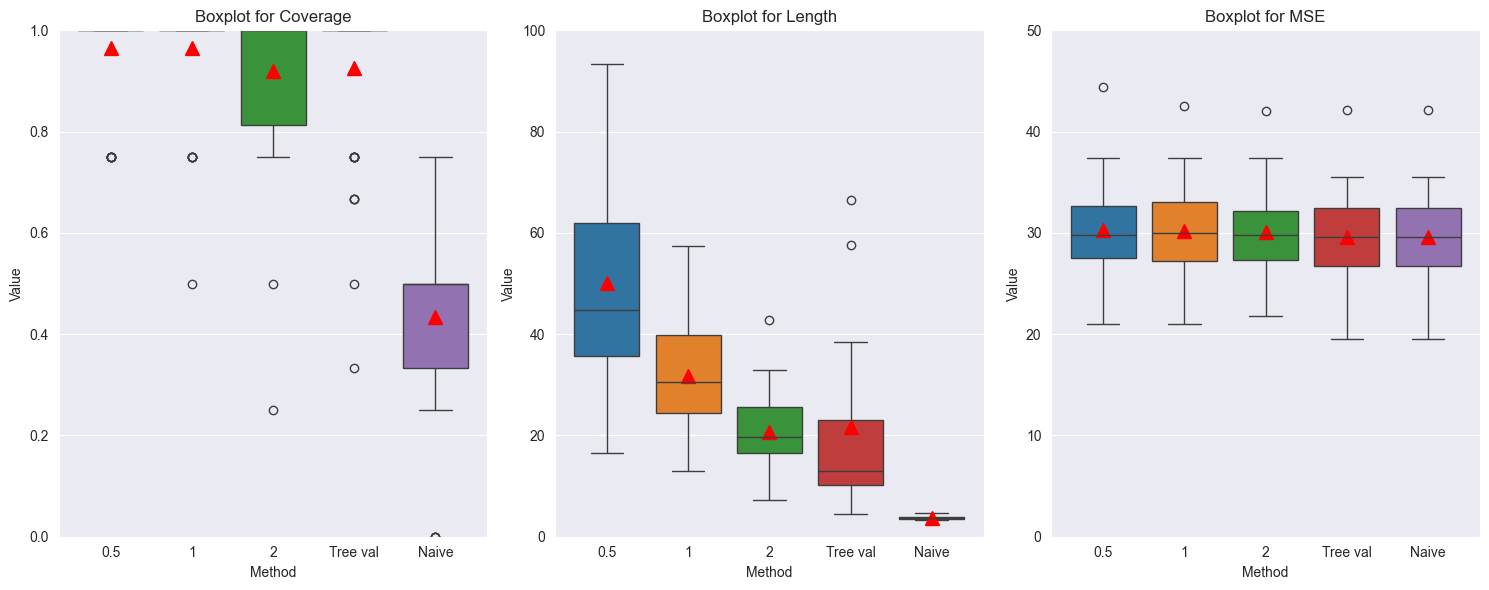

In [25]:
import pandas as pd
boxplots(dfs=[pd.DataFrame(coverage_dict), 
              pd.DataFrame(length_dict), 
              pd.DataFrame(MSE_dict)], 
         metrics=["Coverage", "Length", "MSE"])